<a href="https://colab.research.google.com/github/gudev-db/AI_Stuff/blob/main/DesafioGeiaCarRacing%5BPPO%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proximal Policy Optimitization (PPO)

In [ ]:
!pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.0 MB/s eta 0:00:00


In [ ]:
!pip install stable_baselines3 gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 37.3 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376474 sha256=63f3692c5ed5fb7f134f60fc76756d25a64b7ac867db9aa3836000f03e43c6f3
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [ ]:
import gymnasium
from gymnasium.wrappers import RecordVideo
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.atari_wrappers import WarpFrame
from stable_baselines3.common.vec_env import VecFrameStack, VecVideoRecorder
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import VecTransposeImage
import os
import torch
import numpy
import platform
import stable_baselines3
import matplotlib
import matplotlib.pyplot
from platform import python_version
from importlib.metadata import version

In [ ]:
print(f"Python Version: {platform.python_version()}")
print(f"Torch Version: {version('torch')}")
print(f"Is Cuda Available: {torch.cuda.is_available()}")
print(f"Cuda Version: {torch.version.cuda}")
print(f"Gymnasium Version: {version('gymnasium')}")
print(f"Numpy Version: {version('numpy')}")
print(f"Scipy Version: {version('scipy')}")
print(f"Swig Version: {version('swig')}")
print(f"Stable Baselines3 Version: {version('stable_baselines3')}")
print(f"IPython Version: {version('ipython')}")

Python Version: 3.10.12
Torch Version: 2.5.1+cu121
Is Cuda Available: True
Cuda Version: 12.1
Gymnasium Version: 1.0.0
Numpy Version: 1.26.4
Scipy Version: 1.13.1
Swig Version: 4.3.0
Stable Baselines3 Version: 2.4.0
IPython Version: 7.34.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
env = gymnasium.make("CarRacing-v3", render_mode="rgb_array", lap_complete_percent=0.95, domain_randomize=False, continuous=True)
print("Observation Space Size: ", env.observation_space.shape)
print("Action Space Size: ", env.action_space.shape)
env.close()

<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute


Observation Space Size:  (96, 96, 3)
Action Space Size:  (3,)


/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

In [ ]:
env_str = "CarRacing-v3"
log_dir = "./logs/{}".format(env_str)
gray_scale = True

# If gray_scale True, convert obs to gray scale 84 x 84 image
wrapper_class = WarpFrame if gray_scale else None

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Instanciando Ambiente de Treinamento
env = make_vec_env(env_str, n_envs=1, wrapper_class=wrapper_class) #paraleliza n ambientes no treinamento
env = VecFrameStack(env, n_stack=4) #empilha os ultimos 4 frames em um único tensor para adicionar uma dimensão de temporalidade à análise
env = VecTransposeImage(env) #redimensionando para usar como entrada na cnn

# Instanciando Ambiente de Validação
env_val = make_vec_env(env_str, n_envs=1, wrapper_class=wrapper_class)
env_val = VecFrameStack(env_val, n_stack=4)
env_val = VecTransposeImage(env_val)

#Registrar métricas de treinamento e salvar o melhor modelo encontrado até o momento
eval_callback = EvalCallback(env_val,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             eval_freq=750,
                             render=False,
                             n_eval_episodes=2)

#Inicialização do PPO
model = PPO('CnnPolicy', env, verbose=0, ent_coef=0.005)

#Treinamento
model.learn(total_timesteps=250_000,
            progress_bar=True,
            callback=eval_callback)

# Salvar modelo
model.save(os.path.join(log_dir, "ppo_car_racing"))

# Avaliar modelo
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=50)  # Evaluate with 2 episodes
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Fechar ambiente(s)
env.close()
env_val.close()


Output()

Eval num_timesteps=750, episode_reward=-93.27 +/- 0.36

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=1500, episode_reward=-93.36 +/- 0.23

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=2250, episode_reward=56.73 +/- 86.42

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=3000, episode_reward=38.53 +/- 16.58

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=3750, episode_reward=119.98 +/- 15.51

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=4500, episode_reward=-57.12 +/- 9.93

Episode length: 370.50 +/- 40.50

Eval num_timesteps=5250, episode_reward=-56.02 +/- 6.21

Episode length: 355.00 +/- 50.00

Eval num_timesteps=6000, episode_reward=-51.89 +/- 2.80

Episode length: 371.50 +/- 33.50

Eval num_timesteps=6750, episode_reward=-90.87 +/- 2.30

Episode length: 271.00 +/- 3.00

Eval num_timesteps=7500, episode_reward=-89.85 +/- 1.90

Episode length: 275.00 +/- 3.00

Eval num_timesteps=8250, episode_reward=-100.57 +/- 2.80

Episode length: 731.00 +/- 38.00

Eval num_timesteps=9000, episode_reward=-28.69 +/- 1.90

Episode length: 535.50 +/- 20.50

Eval num_timesteps=9750, episode_reward=-105.06 +/- 3.33

Episode length: 754.50 +/- 9.50

Eval num_timesteps=10500, episode_reward=-85.89 +/- 0.99

Episode length: 267.50 +/- 17.50

Eval num_timesteps=11250, episode_reward=-84.49 +/- 0.80

Eval num_timesteps=12000, episode_reward=-79.60 +/- 6.80

Episode length: 570.50 +/- 319.50

Eval num_timesteps=12750, episode_reward=-0.03 +/- 46.10

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=13500, episode_reward=-30.86 +/- 57.67

Episode length: 605.00 +/- 395.00

Eval num_timesteps=14250, episode_reward=-20.96 +/- 68.98

Episode length: 604.50 +/- 395.50

Eval num_timesteps=15000, episode_reward=-45.59 +/- 20.98

Episode length: 707.00 +/- 293.00

Eval num_timesteps=15750, episode_reward=-49.36 +/- 12.97

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=16500, episode_reward=-30.37 +/- 8.19

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=17250, episode_reward=-30.23 +/- 2.43

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=18000, episode_reward=-27.06 +/- 6.91

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=18750, episode_reward=-15.12 +/- 5.37

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=19500, episode_reward=-19.68 +/- 0.32

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=20250, episode_reward=-24.30 +/- 6.44

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=21000, episode_reward=-14.75 +/- 6.00

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=21750, episode_reward=-36.57 +/- 5.88

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=22500, episode_reward=-39.84 +/- 2.81

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=23250, episode_reward=-26.04 +/- 2.09

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=24000, episode_reward=-25.77 +/- 10.33

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=24750, episode_reward=-20.37 +/- 1.93

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=25500, episode_reward=-26.97 +/- 3.13

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=26250, episode_reward=-21.60 +/- 2.69

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=27000, episode_reward=-47.39 +/- 3.53

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=27750, episode_reward=-41.62 +/- 1.90

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=28500, episode_reward=-43.66 +/- 2.03

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=29250, episode_reward=-57.06 +/- 0.39

Eval num_timesteps=30000, episode_reward=-52.72 +/- 0.52

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=30750, episode_reward=-65.04 +/- 1.63

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=31500, episode_reward=-56.91 +/- 1.28

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=32250, episode_reward=-57.16 +/- 2.43

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=33000, episode_reward=-9.54 +/- 3.95

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=33750, episode_reward=-18.63 +/- 2.25

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=34500, episode_reward=-10.78 +/- 1.08

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=35250, episode_reward=-72.55 +/- 1.24

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=36000, episode_reward=-74.64 +/- 1.22

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=36750, episode_reward=-68.89 +/- 5.93

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=37500, episode_reward=-59.17 +/- 12.86

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=38250, episode_reward=-58.46 +/- 15.90

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=39000, episode_reward=-56.33 +/- 0.91

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=39750, episode_reward=-51.94 +/- 5.89

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=40500, episode_reward=-51.26 +/- 17.68

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=41250, episode_reward=-37.23 +/- 2.97

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=42000, episode_reward=-48.02 +/- 13.17

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=42750, episode_reward=-27.53 +/- 7.53

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=43500, episode_reward=-21.11 +/- 6.48

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=44250, episode_reward=-27.09 +/- 6.03

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=45000, episode_reward=3.77 +/- 27.43

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=45750, episode_reward=-30.86 +/- 2.06

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=46500, episode_reward=-29.93 +/- 4.00

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=47250, episode_reward=-27.92 +/- 6.21

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=48000, episode_reward=-31.85 +/- 7.45

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=48750, episode_reward=-35.95 +/- 5.88

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=49500, episode_reward=-41.89 +/- 10.34

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=50250, episode_reward=-43.89 +/- 1.76

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=51000, episode_reward=-42.79 +/- 4.23

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=51750, episode_reward=-24.88 +/- 1.29

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=52500, episode_reward=10.30 +/- 28.59

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=53250, episode_reward=-54.66 +/- 4.66

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=54000, episode_reward=-62.21 +/- 2.75

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=54750, episode_reward=-63.78 +/- 3.29

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=55500, episode_reward=-44.81 +/- 6.86

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=56250, episode_reward=-48.42 +/- 1.75

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=57000, episode_reward=-28.60 +/- 23.46

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=57750, episode_reward=-36.34 +/- 3.72

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=58500, episode_reward=-9.78 +/- 32.04

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=59250, episode_reward=-38.77 +/- 0.86

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=60000, episode_reward=-12.11 +/- 15.10

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=60750, episode_reward=-3.58 +/- 16.03

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=61500, episode_reward=-7.53 +/- 19.47

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=62250, episode_reward=-27.74 +/- 2.09

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=63000, episode_reward=39.11 +/- 15.05

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=63750, episode_reward=42.37 +/- 20.96

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=64500, episode_reward=0.44 +/- 1.75

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=65250, episode_reward=45.65 +/- 50.08

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=66000, episode_reward=-30.00 +/- 2.72

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=66750, episode_reward=-28.65 +/- 1.06

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=67500, episode_reward=-27.78 +/- 4.70

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=68250, episode_reward=11.90 +/- 47.68

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=69000, episode_reward=-30.05 +/- 5.14

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=69750, episode_reward=-31.97 +/- 12.47

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=70500, episode_reward=7.00 +/- 28.14

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=71250, episode_reward=-3.70 +/- 6.60

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=72000, episode_reward=-25.26 +/- 8.29

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=72750, episode_reward=-7.51 +/- 11.31

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=73500, episode_reward=24.71 +/- 1.12

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=74250, episode_reward=8.08 +/- 37.13

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=75000, episode_reward=6.40 +/- 5.05

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=75750, episode_reward=32.78 +/- 42.22

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=76500, episode_reward=-58.44 +/- 6.12

Episode length: 336.00 +/- 6.00

Eval num_timesteps=77250, episode_reward=-7.66 +/- 47.85

Episode length: 275.50 +/- 63.50

Eval num_timesteps=78000, episode_reward=15.04 +/- 22.78

Episode length: 596.50 +/- 403.50

Eval num_timesteps=78750, episode_reward=75.68 +/- 3.27

Episode length: 613.50 +/- 386.50

Eval num_timesteps=79500, episode_reward=60.50 +/- 15.80

Episode length: 482.00 +/- 256.00

Eval num_timesteps=80250, episode_reward=55.46 +/- 2.79

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=81000, episode_reward=37.23 +/- 36.20

Episode length: 596.00 +/- 404.00

Eval num_timesteps=81750, episode_reward=3.48 +/- 5.30

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=82500, episode_reward=-49.10 +/- 36.20

Episode length: 877.00 +/- 123.00

Eval num_timesteps=83250, episode_reward=28.35 +/- 6.24

Episode length: 611.50 +/- 388.50

Eval num_timesteps=84000, episode_reward=4.16 +/- 4.82

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=84750, episode_reward=47.09 +/- 32.71

Episode length: 616.50 +/- 383.50

Eval num_timesteps=85500, episode_reward=53.13 +/- 18.92

Episode length: 608.00 +/- 392.00

Eval num_timesteps=86250, episode_reward=-10.08 +/- 47.60

Episode length: 266.00 +/- 46.00

Eval num_timesteps=87000, episode_reward=-60.89 +/- 1.66

Episode length: 319.50 +/- 5.50

Eval num_timesteps=87750, episode_reward=-59.30 +/- 2.37

Episode length: 327.50 +/- 4.50

Eval num_timesteps=88500, episode_reward=-25.79 +/- 27.99

Episode length: 322.50 +/- 46.50

Eval num_timesteps=89250, episode_reward=-70.83 +/- 2.20

Episode length: 426.00 +/- 72.00

Eval num_timesteps=90000, episode_reward=-23.54 +/- 46.59

Episode length: 385.00 +/- 105.00

Eval num_timesteps=90750, episode_reward=-54.38 +/- 0.42

Episode length: 345.50 +/- 3.50

Eval num_timesteps=91500, episode_reward=-51.23 +/- 4.38

Episode length: 367.50 +/- 28.50

Eval num_timesteps=92250, episode_reward=-18.54 +/- 43.69

Episode length: 271.00 +/- 45.00

Eval num_timesteps=93000, episode_reward=-43.53 +/- 5.43

Episode length: 328.50 +/- 13.50

Eval num_timesteps=93750, episode_reward=-54.58 +/- 0.12

Episode length: 337.50 +/- 47.50

Eval num_timesteps=94500, episode_reward=35.67 +/- 1.22

Episode length: 224.00 +/- 13.00

Eval num_timesteps=95250, episode_reward=-46.62 +/- 1.93

Episode length: 271.50 +/- 4.50

Eval num_timesteps=96000, episode_reward=-1.70 +/- 43.45

Episode length: 264.50 +/- 30.50

Eval num_timesteps=96750, episode_reward=-56.48 +/- 11.17

Episode length: 386.50 +/- 80.50

Eval num_timesteps=97500, episode_reward=-47.78 +/- 0.61

Eval num_timesteps=98250, episode_reward=-35.32 +/- 23.66

Episode length: 723.00 +/- 277.00

Eval num_timesteps=99000, episode_reward=1.84 +/- 2.19

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=99750, episode_reward=20.82 +/- 4.63

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=100500, episode_reward=54.88 +/- 1.79

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=101250, episode_reward=89.99 +/- 43.56

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=102000, episode_reward=49.82 +/- 20.07

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=102750, episode_reward=136.23 +/- 129.09

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=103500, episode_reward=202.96 +/- 65.46

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=104250, episode_reward=63.32 +/- 35.50

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=105000, episode_reward=64.28 +/- 1.78

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=105750, episode_reward=35.10 +/- 7.76

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=106500, episode_reward=17.35 +/- 1.35

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=107250, episode_reward=7.67 +/- 0.18

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=108000, episode_reward=48.39 +/- 6.05

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=108750, episode_reward=28.97 +/- 16.42

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=109500, episode_reward=69.11 +/- 12.33

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=110250, episode_reward=4.35 +/- 5.94

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=111000, episode_reward=204.57 +/- 12.41

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=111750, episode_reward=47.40 +/- 5.58

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=112500, episode_reward=233.60 +/- 105.75

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=113250, episode_reward=37.71 +/- 23.13

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=114000, episode_reward=11.78 +/- 5.46

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=114750, episode_reward=19.90 +/- 12.76

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=115500, episode_reward=16.48 +/- 4.27

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=116250, episode_reward=-8.18 +/- 8.49

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=117000, episode_reward=50.33 +/- 17.00

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=117750, episode_reward=48.17 +/- 3.77

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=118500, episode_reward=-1.97 +/- 21.11

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=119250, episode_reward=37.11 +/- 13.77

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=120000, episode_reward=22.63 +/- 21.23

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=120750, episode_reward=43.99 +/- 2.68

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=121500, episode_reward=104.24 +/- 88.45

Eval num_timesteps=122250, episode_reward=129.26 +/- 128.67

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=123000, episode_reward=10.97 +/- 1.99

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=123750, episode_reward=150.39 +/- 114.19

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=124500, episode_reward=45.88 +/- 17.17

Eval num_timesteps=125250, episode_reward=19.74 +/- 4.48

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=126000, episode_reward=47.50 +/- 42.41

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=126750, episode_reward=195.16 +/- 64.39

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=127500, episode_reward=13.15 +/- 5.22

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=128250, episode_reward=90.56 +/- 63.35

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=129000, episode_reward=21.70 +/- 0.17

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=129750, episode_reward=28.94 +/- 4.40

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=130500, episode_reward=84.60 +/- 34.99

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=131250, episode_reward=40.41 +/- 3.53

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=132000, episode_reward=104.57 +/- 77.12

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=132750, episode_reward=31.04 +/- 37.58

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=133500, episode_reward=81.58 +/- 82.51

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=134250, episode_reward=132.47 +/- 91.34

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=135000, episode_reward=25.62 +/- 21.97

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=135750, episode_reward=24.07 +/- 4.50

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=136500, episode_reward=7.49 +/- 0.35

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=137250, episode_reward=43.84 +/- 31.16

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=138000, episode_reward=11.16 +/- 1.20

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=138750, episode_reward=29.27 +/- 14.79

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=139500, episode_reward=169.19 +/- 131.48

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=140250, episode_reward=15.31 +/- 14.98

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=141000, episode_reward=0.89 +/- 4.21

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=141750, episode_reward=180.37 +/- 25.47

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=142500, episode_reward=24.14 +/- 10.34

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=143250, episode_reward=155.18 +/- 101.03

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=144000, episode_reward=167.70 +/- 6.55

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=144750, episode_reward=224.13 +/- 150.07

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=145500, episode_reward=192.44 +/- 53.59

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=146250, episode_reward=97.21 +/- 44.73

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=147000, episode_reward=303.41 +/- 43.56

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=147750, episode_reward=248.73 +/- 45.21

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=148500, episode_reward=158.45 +/- 135.81

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=149250, episode_reward=108.90 +/- 39.55

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=150000, episode_reward=46.30 +/- 5.56

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=150750, episode_reward=253.01 +/- 17.37

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=151500, episode_reward=147.24 +/- 77.17

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=152250, episode_reward=323.21 +/- 38.86

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=153000, episode_reward=270.78 +/- 42.26

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=153750, episode_reward=353.40 +/- 54.80

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=154500, episode_reward=68.86 +/- 4.43

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=155250, episode_reward=130.96 +/- 40.28

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=156000, episode_reward=214.91 +/- 6.39

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=156750, episode_reward=203.92 +/- 29.41

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=157500, episode_reward=164.94 +/- 14.94

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=158250, episode_reward=90.60 +/- 64.92

Episode length: 605.00 +/- 395.00

Eval num_timesteps=159000, episode_reward=238.01 +/- 71.99

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=159750, episode_reward=128.32 +/- 95.52

Episode length: 825.50 +/- 174.50

Eval num_timesteps=160500, episode_reward=195.34 +/- 34.33

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=161250, episode_reward=153.35 +/- 83.53

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=162000, episode_reward=335.33 +/- 136.10

Episode length: 671.00 +/- 329.00

Eval num_timesteps=162750, episode_reward=271.79 +/- 267.38

Episode length: 634.50 +/- 365.50

Eval num_timesteps=163500, episode_reward=109.31 +/- 68.64

Episode length: 624.50 +/- 375.50

Eval num_timesteps=164250, episode_reward=53.16 +/- 27.35

Episode length: 792.50 +/- 207.50

Eval num_timesteps=165000, episode_reward=254.59 +/- 83.16

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=165750, episode_reward=164.84 +/- 24.72

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=166500, episode_reward=300.28 +/- 19.65

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=167250, episode_reward=188.13 +/- 19.28

Episode length: 787.00 +/- 25.00

Eval num_timesteps=168000, episode_reward=83.01 +/- 103.70

Episode length: 685.00 +/- 315.00

Eval num_timesteps=168750, episode_reward=188.67 +/- 9.13

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=169500, episode_reward=-22.76 +/- 35.48

Episode length: 671.00 +/- 329.00

Eval num_timesteps=170250, episode_reward=223.02 +/- 43.88

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=171000, episode_reward=50.64 +/- 21.28

Episode length: 300.00 +/- 25.00

Eval num_timesteps=171750, episode_reward=391.00 +/- 181.18

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=172500, episode_reward=152.41 +/- 9.33

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=173250, episode_reward=195.79 +/- 3.53

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=174000, episode_reward=160.81 +/- 83.39

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=174750, episode_reward=90.82 +/- 105.35

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=175500, episode_reward=171.63 +/- 105.59

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=176250, episode_reward=111.68 +/- 33.36

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=177000, episode_reward=94.65 +/- 16.95

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=177750, episode_reward=149.19 +/- 1.67

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=178500, episode_reward=23.98 +/- 26.96

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=179250, episode_reward=169.87 +/- 18.21

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=180000, episode_reward=192.93 +/- 2.61

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=180750, episode_reward=93.32 +/- 106.68

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=181500, episode_reward=86.44 +/- 94.09

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=182250, episode_reward=2.98 +/- 7.74

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=183000, episode_reward=107.61 +/- 39.78

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=183750, episode_reward=148.39 +/- 167.98

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=184500, episode_reward=100.45 +/- 136.62

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=185250, episode_reward=161.90 +/- 122.18

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=186000, episode_reward=112.55 +/- 52.69

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=186750, episode_reward=91.23 +/- 49.28

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=187500, episode_reward=72.76 +/- 74.03

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=188250, episode_reward=18.04 +/- 41.60

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=189000, episode_reward=258.59 +/- 181.87

Episode length: 830.00 +/- 170.00

Eval num_timesteps=189750, episode_reward=192.57 +/- 95.33

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=190500, episode_reward=25.59 +/- 4.84

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=191250, episode_reward=-3.55 +/- 7.23

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=192000, episode_reward=91.93 +/- 35.34

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=192750, episode_reward=79.60 +/- 27.88

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=193500, episode_reward=70.41 +/- 7.29

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=194250, episode_reward=119.69 +/- 83.76

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=195000, episode_reward=-34.16 +/- 13.58

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=195750, episode_reward=46.90 +/- 72.33

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=196500, episode_reward=56.43 +/- 42.88

Eval num_timesteps=197250, episode_reward=0.88 +/- 2.57

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=198000, episode_reward=37.70 +/- 24.37

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=198750, episode_reward=229.41 +/- 207.75

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=199500, episode_reward=5.74 +/- 5.02

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=200250, episode_reward=50.99 +/- 45.92

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=201000, episode_reward=67.90 +/- 57.18

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=201750, episode_reward=164.50 +/- 8.53

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=202500, episode_reward=150.04 +/- 23.93

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=203250, episode_reward=-1.69 +/- 7.70

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=204000, episode_reward=-20.83 +/- 32.35

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=204750, episode_reward=5.81 +/- 7.33

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=205500, episode_reward=102.44 +/- 117.11

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=206250, episode_reward=67.12 +/- 121.02

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=207000, episode_reward=-39.00 +/- 4.52

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=207750, episode_reward=49.13 +/- 112.70

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=208500, episode_reward=-43.58 +/- 17.27

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=209250, episode_reward=40.67 +/- 18.80

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=210000, episode_reward=178.65 +/- 30.17

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=210750, episode_reward=31.16 +/- 62.06

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=211500, episode_reward=289.42 +/- 115.50

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=212250, episode_reward=104.85 +/- 123.97

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=213000, episode_reward=14.23 +/- 23.32

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=213750, episode_reward=156.57 +/- 28.08

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=214500, episode_reward=137.11 +/- 62.89

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=215250, episode_reward=151.77 +/- 8.71

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=216000, episode_reward=17.01 +/- 50.80

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=216750, episode_reward=-27.75 +/- 13.77

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=217500, episode_reward=127.57 +/- 91.51

Eval num_timesteps=218250, episode_reward=67.39 +/- 10.09

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=219000, episode_reward=179.51 +/- 14.80

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=219750, episode_reward=-42.84 +/- 4.70

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=220500, episode_reward=333.44 +/- 369.53

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=221250, episode_reward=-38.36 +/- 3.58

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=222000, episode_reward=143.78 +/- 176.22

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=222750, episode_reward=30.80 +/- 66.83

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=223500, episode_reward=83.88 +/- 107.51

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=224250, episode_reward=-42.06 +/- 3.15

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=225000, episode_reward=79.35 +/- 10.96

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=225750, episode_reward=29.66 +/- 53.27

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=226500, episode_reward=26.64 +/- 64.14

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=227250, episode_reward=-28.65 +/- 2.01

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=228000, episode_reward=-38.89 +/- 3.96

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=228750, episode_reward=27.72 +/- 65.70

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=229500, episode_reward=24.27 +/- 74.96

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=230250, episode_reward=40.65 +/- 77.53

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=231000, episode_reward=22.78 +/- 55.40

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=231750, episode_reward=6.87 +/- 62.80

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=232500, episode_reward=-34.61 +/- 1.48

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=233250, episode_reward=10.11 +/- 40.90

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=234000, episode_reward=16.08 +/- 42.50

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=234750, episode_reward=-43.45 +/- 3.60

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=235500, episode_reward=-38.19 +/- 11.62

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=236250, episode_reward=-36.68 +/- 9.26

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=237000, episode_reward=-1.22 +/- 39.74

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=237750, episode_reward=0.06 +/- 46.73

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=238500, episode_reward=5.37 +/- 37.91

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=239250, episode_reward=-5.69 +/- 42.94

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=240000, episode_reward=-30.71 +/- 2.63

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=240750, episode_reward=-30.66 +/- 3.33

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=241500, episode_reward=-24.91 +/- 10.28

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=242250, episode_reward=-1.47 +/- 37.18

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=243000, episode_reward=-43.50 +/- 8.88

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=243750, episode_reward=2.25 +/- 45.29

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=244500, episode_reward=-32.45 +/- 2.92

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=245250, episode_reward=-39.50 +/- 0.43

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=246000, episode_reward=6.84 +/- 54.97

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=246750, episode_reward=-33.69 +/- 6.87

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=247500, episode_reward=-34.20 +/- 1.61

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=248250, episode_reward=48.86 +/- 14.49

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=249000, episode_reward=9.53 +/- 44.31

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=249750, episode_reward=29.81 +/- 23.28

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=250500, episode_reward=-30.38 +/- 12.29

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=251250, episode_reward=10.76 +/- 62.71

Episode length: 1000.00 +/- 0.00

KeyboardInterrupt: 

#Testes alerando hyperparâmetros e arquitetura da rede

#Testes de Profundidade

##Teste1

In [ ]:

# Initialize the training and validation environments
env_str = "CarRacing-v3"
log_dir = "./logs"

# Wrap environments for frame stacking and image transposing
env = make_vec_env(env_str, n_envs=1)  # One environment for training
env = VecFrameStack(env, n_stack=4)  # Stack 4 frames to give temporal context
env = VecTransposeImage(env)  # Transpose the image to make it compatible with CNN input

# Validation environment
env_val = make_vec_env(env_str, n_envs=1)
env_val = VecFrameStack(env_val, n_stack=4)
env_val = VecTransposeImage(env_val)

# Define an EvalCallback to save the best model and track performance
eval_callback = EvalCallback(env_val,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             eval_freq=750,
                             render=False,
                             n_eval_episodes=2)
model = PPO(
    'CnnPolicy',
    env,
    verbose=0,
    ent_coef=0.005,
    learning_rate=1e-4,
    gamma=0.99,
    n_steps=2048,
    policy_kwargs={
        'net_arch': {'pi': [256, 256, 256], 'vf': [512, 512, 512]},  # Separate architecture for value network (vf)
    },
    clip_range=0.1,
    batch_size=2048
)


# Training loop with evaluation callback
model.learn(total_timesteps=20_000, progress_bar=True, callback=eval_callback)

# Save the trained model
model.save(os.path.join(log_dir, "ppo_car_racing"))

# Evaluate the model
from stable_baselines3.common.evaluation import evaluate_policy
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=50)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Close environments
env.close()
env_val.close()

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20,477/20,000  [ 0:11:50 < 0:00:00 , 47 it/s ]

Mean reward: -52.65 +/- 14.34


##Teste 2 - aprofundando arquitetura apenas

In [ ]:

# Initialize the training and validation environments
env_str = "CarRacing-v3"
log_dir = "./logs"

# Wrap environments for frame stacking and image transposing
env = make_vec_env(env_str, n_envs=1)  # One environment for training
env = VecFrameStack(env, n_stack=4)  # Stack 4 frames to give temporal context
env = VecTransposeImage(env)  # Transpose the image to make it compatible with CNN input

# Validation environment
env_val = make_vec_env(env_str, n_envs=1)
env_val = VecFrameStack(env_val, n_stack=4)
env_val = VecTransposeImage(env_val)

# Define an EvalCallback to save the best model and track performance
eval_callback = EvalCallback(env_val,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             eval_freq=750,
                             render=False,
                             n_eval_episodes=2)
model = PPO(
    'CnnPolicy',
    env,
    verbose=0,
    ent_coef=0.005,
    learning_rate=1e-4,
    gamma=0.99,
    n_steps=2048,
    policy_kwargs={
        'net_arch': {'pi': [256, 256, 256, 256], 'vf': [512, 512, 512, 512]},  # Separate architecture for value network (vf)
    },
    clip_range=0.1,
    batch_size=2048
)


# Training loop with evaluation callback
model.learn(total_timesteps=20_000, progress_bar=True, callback=eval_callback)

# Save the trained model
model.save(os.path.join(log_dir, "ppo_car_racing"))

# Evaluate the model
from stable_baselines3.common.evaluation import evaluate_policy
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=50)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Close environments
env.close()
env_val.close()


Output()

Eval num_timesteps=750, episode_reward=-26.52 +/- 2.06

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=1500, episode_reward=-28.02 +/- 4.67

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=2250, episode_reward=0.14 +/- 6.58

Episode length: 445.00 +/- 5.00

New best mean reward!

Eval num_timesteps=3000, episode_reward=-89.49 +/- 2.50

Episode length: 613.50 +/- 0.50

Eval num_timesteps=3750, episode_reward=-38.05 +/- 51.37

Episode length: 538.50 +/- 73.50

Eval num_timesteps=4500, episode_reward=-57.15 +/- 33.27

Episode length: 670.00 +/- 330.00

Eval num_timesteps=5250, episode_reward=-90.79 +/- 1.31

Episode length: 339.00 +/- 1.00

Eval num_timesteps=6000, episode_reward=-34.62 +/- 52.49

Episode length: 669.00 +/- 331.00

Eval num_timesteps=6750, episode_reward=-21.88 +/- 52.58

Episode length: 660.00 +/- 340.00

KeyboardInterrupt: 

##Teste 3 - Aprofundando a rede

In [ ]:

# Initialize the training and validation environments
env_str = "CarRacing-v3"
log_dir = "./logs"

# Wrap environments for frame stacking and image transposing
env = make_vec_env(env_str, n_envs=1)  # One environment for training
env = VecFrameStack(env, n_stack=4)  # Stack 4 frames to give temporal context
env = VecTransposeImage(env)  # Transpose the image to make it compatible with CNN input

# Validation environment
env_val = make_vec_env(env_str, n_envs=1)
env_val = VecFrameStack(env_val, n_stack=4)
env_val = VecTransposeImage(env_val)

# Define an EvalCallback to save the best model and track performance
eval_callback = EvalCallback(env_val,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             eval_freq=750,
                             render=False,
                             n_eval_episodes=2)
model = PPO(
    'CnnPolicy',
    env,
    verbose=0,
    ent_coef=0.005,
    learning_rate=1e-4,
    gamma=0.99,
    n_steps=2048,
    policy_kwargs={
        'net_arch': {'pi': [256, 256, 256, 256, 256], 'vf': [512, 512, 512, 512, 512]},  # Separate architecture for value network (vf)
    },
    clip_range=0.1,
    batch_size=2048
)


# Training loop with evaluation callback
model.learn(total_timesteps=20_000, progress_bar=True, callback=eval_callback)

# Save the trained model
model.save(os.path.join(log_dir, "ppo_car_racing"))

# Evaluate the model
from stable_baselines3.common.evaluation import evaluate_policy
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=50)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Close environments
env.close()
env_val.close()

##Teste 4 - aprofundando a rede

In [ ]:
# Initialize the training and validation environments
env_str = "CarRacing-v3"
log_dir = "./logs"

# Wrap environments for frame stacking and image transposing
env = make_vec_env(env_str, n_envs=1)  # One environment for training
env = VecFrameStack(env, n_stack=4)  # Stack 4 frames to give temporal context
env = VecTransposeImage(env)  # Transpose the image to make it compatible with CNN input

# Validation environment
env_val = make_vec_env(env_str, n_envs=1)
env_val = VecFrameStack(env_val, n_stack=4)
env_val = VecTransposeImage(env_val)

# Define an EvalCallback to save the best model and track performance
eval_callback = EvalCallback(env_val,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             eval_freq=750,
                             render=False,
                             n_eval_episodes=2)
model = PPO(
    'CnnPolicy',
    env,
    verbose=0,
    ent_coef=0.005,
    learning_rate=1e-4,
    gamma=0.99,
    n_steps=2048,
    policy_kwargs={
        'net_arch': {'pi': [256, 256, 256, 256, 256], 'vf': [512, 512, 512, 512, 512]},  # Separate architecture for value network (vf)
    },
    clip_range=0.1,
    batch_size=2048
)


# Training loop with evaluation callback
model.learn(total_timesteps=20_000, progress_bar=True, callback=eval_callback)

# Save the trained model
model.save(os.path.join(log_dir, "ppo_car_racing"))

# Evaluate the model
from stable_baselines3.common.evaluation import evaluate_policy
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=50)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Close environments
env.close()
env_val.close()

##Teste 5 - Aprofundando a rede

In [ ]:
# Initialize the training and validation environments
env_str = "CarRacing-v3"
log_dir = "./logs"

# Wrap environments for frame stacking and image transposing
env = make_vec_env(env_str, n_envs=1)  # One environment for training
env = VecFrameStack(env, n_stack=4)  # Stack 4 frames to give temporal context
env = VecTransposeImage(env)  # Transpose the image to make it compatible with CNN input

# Validation environment
env_val = make_vec_env(env_str, n_envs=1)
env_val = VecFrameStack(env_val, n_stack=4)
env_val = VecTransposeImage(env_val)

# Define an EvalCallback to save the best model and track performance
eval_callback = EvalCallback(env_val,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             eval_freq=750,
                             render=False,
                             n_eval_episodes=2)
model = PPO(
    'CnnPolicy',
    env,
    verbose=0,
    ent_coef=0.005,
    learning_rate=1e-4,
    gamma=0.99,
    n_steps=2048,
    policy_kwargs={
        'net_arch': {'pi': [256, 256, 256, 256, 256, 256], 'vf': [512, 512, 512, 512, 512, 512]},  # Separate architecture for value network (vf)
    },
    clip_range=0.1,
    batch_size=2048
)


# Training loop with evaluation callback
model.learn(total_timesteps=20_000, progress_bar=True, callback=eval_callback)

# Save the trained model
model.save(os.path.join(log_dir, "ppo_car_racing"))

# Evaluate the model
from stable_baselines3.common.evaluation import evaluate_policy
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=50)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Close environments
env.close()
env_val.close()

#Testes de Alargamento ou estreitamento

In [ ]:
# Initialize the training and validation environments
env_str = "CarRacing-v3"
log_dir = "./logs"

# Wrap environments for frame stacking and image transposing
env = make_vec_env(env_str, n_envs=1)  # One environment for training
env = VecFrameStack(env, n_stack=4)  # Stack 4 frames to give temporal context
env = VecTransposeImage(env)  # Transpose the image to make it compatible with CNN input

# Validation environment
env_val = make_vec_env(env_str, n_envs=1)
env_val = VecFrameStack(env_val, n_stack=4)
env_val = VecTransposeImage(env_val)

# Define an EvalCallback to save the best model and track performance
eval_callback = EvalCallback(env_val,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             eval_freq=750,
                             render=False,
                             n_eval_episodes=2)
model = PPO(
    'CnnPolicy',
    env,
    verbose=0,
    ent_coef=0.005,
    learning_rate=1e-4,
    gamma=0.99,
    n_steps=2048,
    policy_kwargs={
        'net_arch': {'pi': [512, 512, 512], 'vf': [1024, 1024, 1024]},  # Separate architecture for value network (vf)
    },
    clip_range=0.1,
    batch_size=2048
)


# Training loop with evaluation callback
model.learn(total_timesteps=200_000, progress_bar=True, callback=eval_callback)

# Save the trained model
model.save(os.path.join(log_dir, "ppo_car_racing"))

# Evaluate the model
from stable_baselines3.common.evaluation import evaluate_policy
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=50)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Close environments
env.close()
env_val.close()

Output()

Eval num_timesteps=750, episode_reward=-4.23 +/- 32.52

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=1500, episode_reward=10.51 +/- 24.91

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=2250, episode_reward=-52.02 +/- 1.69

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=3000, episode_reward=-103.67 +/- 1.68

Episode length: 376.00 +/- 2.00

Eval num_timesteps=3750, episode_reward=-105.05 +/- 1.19

Episode length: 373.00 +/- 0.00

Eval num_timesteps=4500, episode_reward=-16.45 +/- 35.41

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=5250, episode_reward=-53.38 +/- 2.25

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=6000, episode_reward=-55.16 +/- 0.77

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=6750, episode_reward=-26.16 +/- 35.25

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=7500, episode_reward=-55.14 +/- 0.42

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=8250, episode_reward=-90.68 +/- 27.45

Episode length: 785.50 +/- 214.50

Eval num_timesteps=9000, episode_reward=-117.74 +/- 0.84

Episode length: 570.00 +/- 0.00

Eval num_timesteps=9750, episode_reward=-96.20 +/- 29.65

Episode length: 786.00 +/- 214.00

Eval num_timesteps=10500, episode_reward=-62.13 +/- 0.20

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=11250, episode_reward=-57.55 +/- 3.16

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=12000, episode_reward=-61.29 +/- 3.11

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=12750, episode_reward=-49.51 +/- 6.19

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=13500, episode_reward=-49.98 +/- 0.89

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=14250, episode_reward=-49.73 +/- 0.45

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=15000, episode_reward=-70.19 +/- 1.33

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=15750, episode_reward=-71.10 +/- 0.32

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=16500, episode_reward=-70.90 +/- 1.41

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=17250, episode_reward=-72.87 +/- 0.64

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=18000, episode_reward=-70.26 +/- 0.33

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=18750, episode_reward=-48.91 +/- 5.95

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=19500, episode_reward=-59.04 +/- 5.37

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=20250, episode_reward=-51.45 +/- 11.05

Episode length: 1000.00 +/- 0.00

Mean reward: -71.54 +/- 3.10


In [ ]:
# Initialize the training and validation environments
env_str = "CarRacing-v3"
log_dir = "./logs"

# Wrap environments for frame stacking and image transposing
env = make_vec_env(env_str, n_envs=1)  # One environment for training
env = VecFrameStack(env, n_stack=4)  # Stack 4 frames to give temporal context
env = VecTransposeImage(env)  # Transpose the image to make it compatible with CNN input

# Validation environment
env_val = make_vec_env(env_str, n_envs=1)
env_val = VecFrameStack(env_val, n_stack=4)
env_val = VecTransposeImage(env_val)

# Define an EvalCallback to save the best model and track performance
eval_callback = EvalCallback(env_val,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             eval_freq=750,
                             render=False,
                             n_eval_episodes=2)
model = PPO(
    'CnnPolicy',
    env,
    verbose=0,
    ent_coef=0.005,
    learning_rate=1e-4,
    gamma=0.99,
    n_steps=2048,
    policy_kwargs={
        'net_arch': {'pi': [1024, 1024, 1024], 'vf': [2048, 2048, 2048]},  # Separate architecture for value network (vf)
    },
    clip_range=0.1,
    batch_size=2048
)


# Training loop with evaluation callback
model.learn(total_timesteps=20_000, progress_bar=True, callback=eval_callback)

# Save the trained model
model.save(os.path.join(log_dir, "ppo_car_racing"))

# Evaluate the model
from stable_baselines3.common.evaluation import evaluate_policy
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=50)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Close environments
env.close()
env_val.close()

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20,474/20,000  [ 0:12:00 < 0:00:00 , 13 it/s ]

In [ ]:
# Cria ambiente de avaliação
env = make_vec_env(env_str, n_envs=1, seed=0, wrapper_class=WarpFrame)
env = VecFrameStack(env, n_stack=4)
env = VecTransposeImage(env)

# Carrega melhor modelo
best_model_path = os.path.join(log_dir, "best_model.zip")
best_model = PPO.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=20)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Grava vídeo do melhor modelo rodando
env = VecVideoRecorder(env, "./videos/",
                       video_length=10000,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix="best_model_car_racing_ppo")

obs = env.reset()
for _ in range(10000):
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
        break

env.close()

Best Model - Mean reward: 164.67 +/- 96.51


/usr/local/lib/python3.10/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


Moviepy - Building video /content/videos/best_model_car_racing_ppo-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/videos/best_model_car_racing_ppo-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/best_model_car_racing_ppo-step-0-to-step-10000.mp4


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


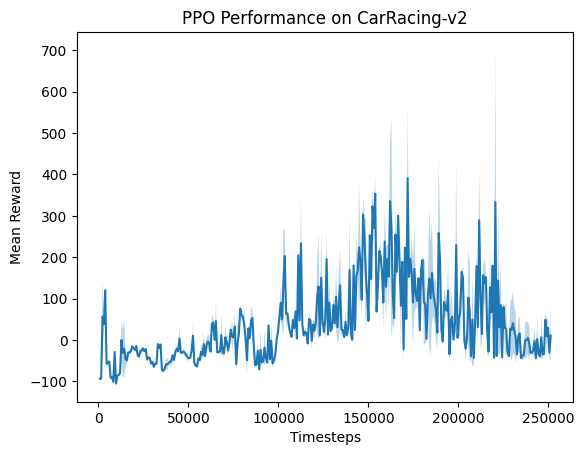

In [ ]:

data = numpy.load(os.path.join(log_dir, "evaluations.npz"))


timesteps = data['timesteps']
results = data['results']

mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title('PPO Performance on CarRacing-v3')
matplotlib.pyplot.show()

#Avaliação GEIA

In [ ]:
def avaliacao(modelo_treinado, run_pista='CarRacing-v3'):
pygame.init()
env = gym.make(run_pista, render_mode='human')
aceleracao = 0 # Soma das magnitudes de aceleração aplicadas pelo agente
tempo = 0 # Medido em número de iterações durante a execução do episódio
punicoes = 0 # Contagem de eventos de colisão ou saídas de pista
# MODELO CRIADO PELO DESAFIANTE:
# Insira o código de controle para o carro, usando
`modelo_treinado` para determinar
# as ações de aceleração, direção e frenagem ao longo da corrida.
pontuacao=(aceleracao * tempo)/(punicoes if punicoes > 0 else 1)
env.close()
pygame.quit()
return pontuacao